# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import bottleneck as bn
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import re
import nltk
import gensim
import spacy
import pyLDAvis
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from sklearn.utils import Bunch
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en_core_web_md')

/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdelbyf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abdelbyf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/a

/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/abdelbyf/anaconda3/lib/python3.10/site-packages/catalogue/__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Users/abdelbyf/anaconda3/lib/py

# Import & Transform Data

In [2]:
# Define the file path
file_path = '/Users/abdelbyf/Desktop/Github/Trilo.txt'

# Load the text file and split the documents using the delimiter
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

# Split each document by the delimiter
documents = content.split('------------------------------------')

# Assign targets to each individual document
# Since all documents belong to the same category, use a single target index
all_data = []
all_target = []
target_names = ['The Rebel', 'The Misunderstanding', 'The Myth Of Sisyphus']

for idx, doc in enumerate(documents):
    # Split each document into smaller documents (chapters)
    smaller_documents = doc.split('---------------')
    
    # Append smaller documents to all_data
    all_data.extend(smaller_documents)
    
    # Assign the same target index for all smaller documents from this book
    all_target.extend([idx] * len(smaller_documents))

# Convert all_target to numpy array
all_target = np.array(all_target)

# Create a Bunch object similar to the 20 Newsgroups dataset
camus_dataset = Bunch(
    data=all_data,
    target=all_target,
    target_names=target_names,
    DESCR="Three large documents by Albert Camus.",
)

# Inspect the created dataset
print(f"Number of documents: {len(camus_dataset.data)}")
print(f"Number of categories: {len(camus_dataset.target_names)}")
print("Categories:", camus_dataset.target_names)

Number of documents: 73
Number of categories: 3
Categories: ['The Rebel', 'The Misunderstanding', 'The Myth Of Sisyphus']


In [3]:
def camus_dataset_to_csv():
    df = pd.DataFrame([camus_dataset.data, camus_dataset.target.tolist()]).T
    df.columns = ['text', 'target']
    return df.head(5)
camus_dataset_to_csv()

,text,target
0,Albert Camus : The Rebel\n\nForeword\nWith the...,0
1,\nIntroduction\n\nThere are crimes of passion ...,0
2,\nPart One The Rebel\n\nWhat is a rebel? A man...,0
3,\nPart Two Metaphysical Rebellion\n\nMetaphysi...,0
4,\nAbsolute Negation\n\nHistorically speaking t...,0


In [4]:
camus_dataset.target_names

['The Rebel', 'The Misunderstanding', 'The Myth Of Sisyphus']

In [5]:
# Finding frequency of each category
targets, frequency = np.unique(camus_dataset.target, return_counts=True)

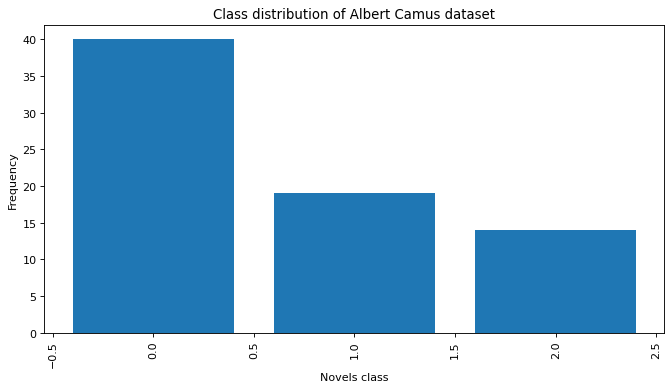

In [7]:
# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of Albert Camus dataset')
plt.xlabel('Novels class')
plt.ylabel('Frequency')
plt.show()

# Data preparation

In [8]:
# Define custom stopwords
custom_stopwords = [
    "I", "a", "don't", "madame", "monsieur", "can", "then", "be", "this",
    "these", "this", "this", "like", "thus", "if", "and", "the", "the", "the",
    "two", "three", "also", "all", "all", "more", "it", "according", "fact",
    "after", "again", "THE", "OF", "US", "The", "AND", "TO", "OR", "IS", "His", "He", "ra", 
    "Him", "And", "You", "It", "If", "The", "In", "us", "It", "For", "The", 
    "In", "They", "We", "also"
]

# Combine NLTK's English stopwords with custom stopwords
stop_words = set(stopwords.words('english')).union(custom_stopwords)

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove non-alphabetic tokens and single characters
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

documents = camus_dataset.data
processed_docs = [preprocess(doc) for doc in documents]

# Convert processed_docs to a DataFrame
df_processed = pd.DataFrame({'Original Text': documents, 'Processed Tokens': processed_docs})

# Display the processed data
print(df_processed)

                                        Original Text  \
0   Albert Camus : The Rebel\n\nForeword\nWith the...   
1   \nIntroduction\n\nThere are crimes of passion ...   
2   \nPart One The Rebel\n\nWhat is a rebel? A man...   
3   \nPart Two Metaphysical Rebellion\n\nMetaphysi...   
4   \nAbsolute Negation\n\nHistorically speaking t...   
..                                                ...   
68  \nAbsurd Creation\nPhilosophy and Fiction\nAll...   
69  \nKirilov\nAll of Dostoevskys heroes question ...   
70  \nEphemeral Creation\nAt this point I perceive...   
71  \nThe Myth Of Sisyphus\nThe gods had condemned...   
72  \nAppendix Hope and the Absurd in the Work of ...   

                                     Processed Tokens  
0   [albert, camus, rebel, foreword, publication, ...  
1   [introduction, crimes, passion, crimes, logic,...  
2   [part, one, rebel, rebel, man, says, whose, re...  
3   [part, metaphysical, rebellion, metaphysical, ...  
4   [absolute, negation, historical

In [9]:
## Lemmatization: keep only the root forms
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

df_processed["text_word_token0"] = lemmatization(df_processed["Processed Tokens"], allowed_postags=['NOUN', 'ADJ'])

In [10]:
documents_1 = df_processed['text_word_token0'].tolist()
def filter_words(doc):
    return [word for word in doc if len(word) > 2] 

# Apply filtering to each sublist in Document_1
filtered_document = [filter_words(doc) for doc in documents_1]

In [11]:
## Create the dictionary and corpus
id2word = corpora.Dictionary(filtered_document)
corpus = [id2word.doc2bow(doc) for doc in filtered_document]

In [12]:
# Make sure all tokenized items are lists
df_processed = df_processed[df_processed["text_word_token0"].map(type) == list]
df_processed.reset_index(drop=True, inplace=True)

print("After cleaning and excluding short articles, the dataframe now has:", len(df_processed), "articles")

After cleaning and excluding short articles, the dataframe now has: 73 articles


In [23]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=3, random_state=42, update_every=1, chunksize=100, passes=10,
                     iterations=100, alpha='auto')

In [24]:
# Calculate Coherence and perplexity

## Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_document, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Coherence Score:  0.3169899824576237

Perplexity:  -7.584722978238822


# Visualize data Results

In [25]:
# Inspect topics
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.018*"man" + 0.011*"world" + 0.009*"life" + 0.009*"rebellion" + 0.008*"time" + 0.008*"history"')
(1, '0.013*"rebellion" + 0.008*"art" + 0.007*"man" + 0.007*"world" + 0.005*"sisyphu" + 0.004*"beauty"')
(2, '0.011*"history" + 0.010*"marx" + 0.010*"revolution" + 0.008*"man" + 0.007*"time" + 0.007*"society"')


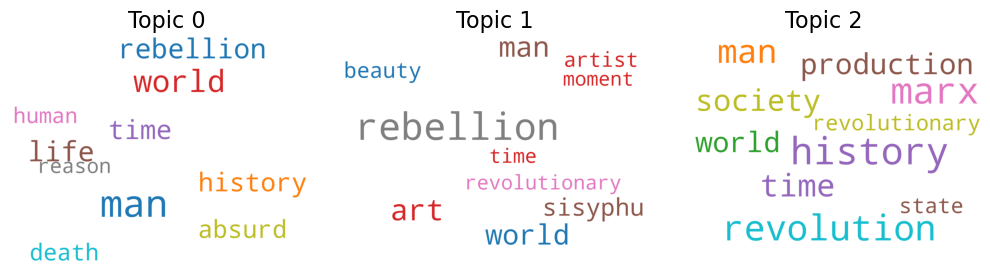

In [27]:
# Define colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Define WordCloud parameters
cloud = WordCloud(stopwords=stopwords.words('english'),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

# Get topics and sort them by topic number
topics = lda_model.show_topics(num_topics=3, formatted=False)

# Create a grid for word clouds
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
## Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda_visualization.html')
pyLDAvis.display(vis)